In [1]:
import os

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import roc_curve, auc, precision_recall_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model

In [2]:
# Load the dataset
RNDSTATE = 42

ROOT_PATH = os.getcwd()
PATH = os.path.join(ROOT_PATH, "input", "creditcard.csv")

df = pd.read_csv(PATH, delimiter=",")
df = df.values

labels = df[:, -1]
data = df[:, 0:-1]

X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, stratify=labels, random_state=RNDSTATE)

In [3]:
# General info
unique_values, cnt = np.unique(labels, return_counts=True)

print("Nbr of class:", 2)
print("Nbr of geniune transactions (class=0): ", cnt[0])
print("Nbr of fraudulent transactions (class=1): ", cnt[1])
print("Input shape:", data.shape)

Nbr of class: 2
Nbr of geniune transactions (class=0):  284315
Nbr of fraudulent transactions (class=1):  492
Input shape: (284807, 30)


In [4]:
# Substract the mean and scale to unit variance
scaler_train = StandardScaler()
scaler_test = StandardScaler()

# bkgd = background, sig=signal
X_train_bkgd = X_train[y_train == 0]
X_train_bkgd = scaler_train.fit_transform(X_train_bkgd)
X_train_bkgd = tf.cast(X_train_bkgd, tf.float32)

X_test = scaler_test.fit_transform(X_test)
X_test = tf.cast(X_test, tf.float32)

In [5]:
# Autoencoder architecture
class AutoEncoder(Model):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = tf.keras.Sequential([
          layers.Dense(30, activation="relu"),
          layers.Dense(16, activation="relu"),
          layers.Dense(8, activation="relu")
        ])

        self.decoder = tf.keras.Sequential([
          layers.Dense(16, activation="relu"),
          layers.Dense(24, activation="relu"),
          layers.Dense(30, activation="sigmoid")
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

autoencoder = AutoEncoder()

In [6]:
autoencoder.compile(optimizer='adam', loss='mae')

# Model weights are saved at the end of every epoch, if it's the best seen so far
checkpoint_filepath = 'tmp/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True
)

EPOCHS = 100
history = autoencoder.fit(
    X_train_bkgd,
    X_train_bkgd, 
    epochs=EPOCHS, 
    batch_size=512,
    validation_data=(X_test, X_test),
    shuffle=True,
    callbacks=[model_checkpoint_callback]
)

# We load the best weight into the model
autoencoder.load_weights(checkpoint_filepath)

Epoch 1/100
445/445 [==============================] - 4s 7ms/step - loss: 0.6584 - val_loss: 0.6002
Epoch 2/100
445/445 [==============================] - 3s 7ms/step - loss: 0.5929 - val_loss: 0.5737
Epoch 3/100
445/445 [==============================] - 3s 7ms/step - loss: 0.5757 - val_loss: 0.5646
Epoch 4/100
445/445 [==============================] - 3s 7ms/step - loss: 0.5666 - val_loss: 0.5557
Epoch 5/100
445/445 [==============================] - 3s 7ms/step - loss: 0.5603 - val_loss: 0.5507
Epoch 6/100
445/445 [==============================] - 3s 6ms/step - loss: 0.5555 - val_loss: 0.5467
Epoch 7/100
445/445 [==============================] - 3s 7ms/step - loss: 0.5523 - val_loss: 0.5438
Epoch 8/100
445/445 [==============================] - 3s 6ms/step - loss: 0.5495 - val_loss: 0.5415
Epoch 9/100
445/445 [==============================] - 3s 7ms/step - loss: 0.5476 - val_loss: 0.5400
Epoch 10/100
445/445 [==============================] - 3s 7ms/step - loss: 0.5462 - val_lo

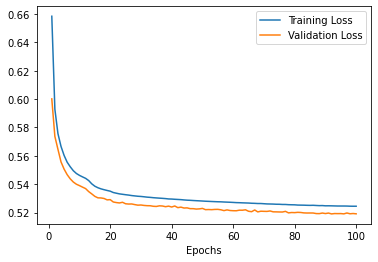

In [7]:
# Ploting the training/validation loss scores
xaxis = list(range(1, EPOCHS + 1))

plt.plot(xaxis, history.history["loss"], label="Training Loss")
plt.plot(xaxis, history.history["val_loss"], label="Validation Loss")
plt.xlabel('Epochs')
plt.legend()

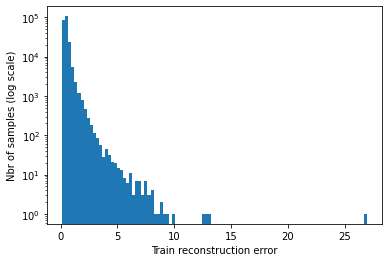

In [9]:
# Reconstruction error plot
# If the AE is well trained, the error should be distributed close to 0
reconstructions = autoencoder.predict(X_train_bkgd)
train_loss = tf.keras.losses.mae(reconstructions, X_train_bkgd)

plt.hist(train_loss[None,:], bins=100)
plt.xlabel("Train reconstruction error")
plt.ylabel("Nbr of samples (log scale)")
plt.yscale("log")
plt.show()

In [10]:
threshold = np.mean(train_loss) + np.std(train_loss)
print("Threshold: ", threshold)

Threshold:  0.8435227


In [14]:
# Reconstruction error on the test which contains geniune and fraudulent transaction
reconstruction_test = autoencoder.predict(X_test)
test_loss = tf.keras.losses.mae(reconstruction_test, X_test)

# If the reconstruction error is smaller than the threshold assign True else False
# In other words, if the error is smaller than the threshold it means that the AE was able to reconstruct it quite well
# and so can say that it is very likely a genuine transaction.
y_pred = tf.math.less(threshold, test_loss)

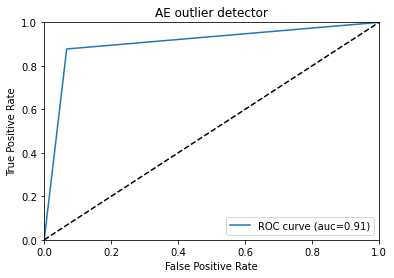

In [15]:
# Receiver Operating Characteristic Curve
fpr, tpr, _ = roc_curve(y_test, y_pred)

plt.plot(fpr, tpr, label='ROC curve (auc=%0.2f)' % auc(fpr, tpr))
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AE outlier detector')
plt.legend(loc="best")
plt.savefig('AE_outlier_roc_curve.png', bbox_inches='tight')

plt.show()

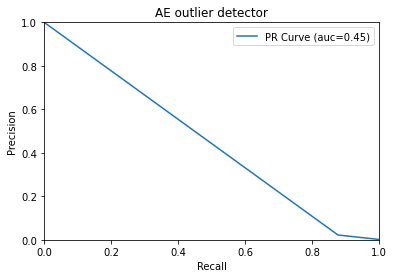

In [16]:
# Precision Recall Curve 
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)

plt.plot(recall, precision, label='PR Curve (auc=%0.2f)' % auc(recall, precision))
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('AE outlier detector')
plt.legend(loc="best")
plt.savefig('AE_outlier_pr_curve.png', bbox_inches='tight')

plt.show()